In [1]:
import os
import cv2
import torch
import random
import numpy as np
from PIL import Image
from torch import optim
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import Conv_Att_MCI_Dataset
from dataset import Conv_Att_MCI_Dataset_v2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from models import BaseModel, VGG16GradCAM, ConvAttnModel
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc as auc_score, confusion_matrix
# GPUtil 라이브러리를 사용하여 GPU 사용량 확인
import GPUtil

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # 사용 가능한 GPU 중에서 가장 메모리 사용량이 적은 GPU 선택
    gpus = GPUtil.getGPUs()
    # least_used_GPU = min(GPUs, key=lambda gpu: gpu.memoryUsed)
    gpu_used = {gpu.id:gpu.memoryUsed for gpu in gpus}
    min_gpu_id = min(gpu_used, key=lambda k:gpu_used[k])
    print("\n".join(["GPU %d: %5dMB"%(i, gpu_used[i]) for i in gpu_used]))
device = torch.device('cuda:%d'%min_gpu_id if torch.cuda.is_available() else 'cpu')
print(device)

GPU 0:     3MB
GPU 1:  4503MB
cuda:0


In [3]:
# Dataset
img_type = ['clock', 'copy', 'trail'] #clock, copy, trail
label_type = 'soft' # soft, hard
IMAGE_SIZE = (256,256)

# Model
model_type = 'conv_att' # base, vgg16_grad_cam, conv_att
backbone_freezing = True

## Conv-Att
h_dim_attn = 128
n_heads = 1
h_dim_fc = 512
n_layers = 1#10

# training
batch_size = 64
n_epochs = 100
best_loss = np.inf
best_epoch = 0
best_flag = False

# optimizer
lr = 1e-5
beta_1 = 0.9
beta_2 = 0.99
eps = 1e-7
backbone_lr = 1e-6

## Early stopping
es_size = 4

# Save directory
savedir = './checkpoint'
savedir = os.path.join(savedir, "img_%s"%('_'.join(img_type)))
savedir = os.path.join(savedir, "model_%s"%(model_type))
savedir = os.path.join(savedir, "freeze_%s"%('%s'%backbone_freezing+'_lr_%s'%backbone_lr if not backbone_freezing else backbone_freezing))
savedir = os.path.join(savedir, 'label_%s'%label_type)
if model_type == 'conv_att':
    savedir = os.path.join(savedir, 'h_dim_attn_%d_n_heads_%d_h_dim_fc_%d_n_layers_%d'%(h_dim_attn, n_heads, h_dim_fc, n_layers))
savedir = os.path.join(savedir, 'seed_%d'%SEED)

os.makedirs(savedir, exist_ok=True)
print(savedir)

./checkpoint/img_clock_copy_trail/model_conv_att/freeze_True/label_soft/h_dim_attn_128_n_heads_1_h_dim_fc_512_n_layers_1/seed_1234


In [4]:
dataset = Conv_Att_MCI_Dataset_v2(img_type, label_type)
dataset_trn, dataset_val, dataset_test = dataset.split_trn_val_test()
dl_trn = DataLoader(dataset_trn, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [5]:
if model_type == 'base':
    model = BaseModel(img_type, backbone_freezing).to(device)
elif model_type == 'vgg16_grad_cam':
    model = VGG16GradCAM(img_type, backbone_freezing).to(device)
elif model_type == 'conv_att':
    model = ConvAttnModel(img_type, h_dim_attn, n_heads, h_dim_fc, n_layers, backbone_freezing).to(device)
else:
    raise ValueError("%s is invalid type"%model_type)

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
n_tot, n_params_trn, n_params_frozen = 0,0,0
params_trained = []
for n,p in model.named_parameters():
    n_tot += p.numel()
    if p.requires_grad:
        n_params_trn += p.numel()
        params_trained.append(n)
    else:
        n_params_frozen += p.numel()
print("| Total # parameters %d | Trainable %d | Frozen %d |"%(n_tot, n_params_trn, n_params_frozen))

| Total # parameters 45396802 | Trainable 1252738 | Frozen 44144064 |


In [7]:
common_settings = {'betas':[beta_1, beta_2], 'eps':eps}

backbone_params, others_params = {'names':[], 'params':[]}, {'names':[], 'params':[]}
for n,p in model.named_parameters():
    if 'vgg16' in n:
        backbone_params['names'].append(n)
        backbone_params['params'].append(p)
    else:
        others_params['names'].append(n)
        others_params['params'].append(p)

optimizer = optim.Adam([
    {'params':backbone_params['params'], 'lr':backbone_lr, **common_settings},
    {'params':others_params['params'], 'lr':lr, **common_settings},
])

In [8]:
def get_metrics(preds, targets):
    preds = np.array(preds) if type(preds) != np.ndarray else preds
    targets = np.array(targets) if type(targets) != np.ndarray else preds
    assert len(preds.shape) == 1 and len(targets.shape) == 1
    
    acc = accuracy_score(targets>=0.5, preds>=0.5) * 100
    f1 = f1_score(targets>=0.5, preds>=0.5)
    tpr, fpr, thres = roc_curve(targets>=0.5, preds)
    auc = auc_score(tpr,fpr)
    
    tn, fp, fn, tp = confusion_matrix(targets>=0.5, preds>=0.5).ravel()
    recall = sensitivity = tp / (tp + fn + 1e-7)
    specificity = selectivity = tn / (fp + tn + 1e-7)
    precision = tp / (tp + fp + 1e-7)
    
    return acc, f1, auc, recall, precision, specificity

def save_ckpt(epoch, model, optimizer, results, savepath):
    ckpt = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': results['loss']['val'][-1],
        'accuracy': results['accuracy']['val'][-1],
        'results': results
    }
    torch.save(ckpt, savepath)
    return ckpt

In [9]:
from copy import deepcopy
cls_token_before = deepcopy(model.cls_token)
print(cls_token_before)

Parameter containing:
tensor([[[ 0.3911,  1.6163, -1.1899, -0.4299, -0.8523,  0.0165,  1.0824,
           0.5948,  0.0873, -0.1045,  0.5811, -0.3842,  0.0647, -1.0877,
           0.2042,  0.1420, -1.0862,  1.2452, -0.2125, -0.3730, -2.3097,
          -1.4064,  2.0252,  1.4214, -1.4874,  0.8604,  0.3300,  0.9048,
          -0.2621,  0.1783, -0.2832,  0.6042,  1.4539,  0.6291,  0.1965,
           1.7345,  0.3580, -0.6834,  0.6823,  0.9133, -0.0701, -0.1631,
           1.3294,  0.0941, -0.8470,  0.1852,  0.8560, -0.6472, -0.0043,
          -0.8410, -0.2717, -0.6968,  1.1934,  0.3591,  0.8389, -0.1573,
           0.2037,  0.3403, -0.4379, -0.8101,  0.1297, -1.3858,  2.6133,
          -0.0081,  0.2310, -0.6074, -0.0939, -0.9859,  0.6325,  2.0244,
           0.3382,  0.4835, -0.4097, -0.8773, -0.4129, -0.6342, -0.9232,
           1.0853, -1.8508,  0.0542,  0.9324, -1.1367, -0.5400, -1.7671,
          -0.2625,  0.2647,  0.2245,  0.4423, -2.0041, -0.9980,  0.1159,
           1.1926,  0.6900,  

In [10]:
results = {
    'loss':{'trn':[], 'val':[], 'test':[]},
    'f1-score':{'trn':[], 'val':[], 'test':[]},
    'accuracy':{'trn':[], 'val':[], 'test':[]},
    'auc':{'trn':[], 'val':[], 'test':[]},
    'recall':{'trn':[], 'val':[], 'test':[]},
    'precision':{'trn':[], 'val':[], 'test':[]},
    'specificity':{'trn':[], 'val':[], 'test':[]},
    'pred':{'trn':[], 'val':[], 'test':[]},
    'target':{'trn':[], 'val':[], 'test':[]},
}
es_queue, es_flag = deque(maxlen=es_size), False
for epoch in range(n_epochs):
    losses, preds, targets = [],[],[]
    model.train()
    for x, label, score, info in dl_trn:
        for i in range(len(x)):
            x[i] = x[i].to(device)
        score = score.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, score)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        preds.extend(y_prob.detach().cpu())
        targets.extend(label)
    
    acc, f1, auc, recall, precision, specificity = get_metrics(preds, targets)
    
    results['loss']['trn'].append(np.mean(losses))
    results['f1-score']['trn'].append(f1)
    results['accuracy']['trn'].append(acc)
    results['auc']['trn'].append(auc)
    results['recall']['trn'].append(recall)
    results['precision']['trn'].append(precision)
    results['specificity']['trn'].append(specificity)
    results['pred']['trn'].append(preds)
    results['target']['trn'].append(targets)

    losses, preds, targets = [],[],[]
    model.eval()
    for x, label, score, info in dl_val:
        for i in range(len(x)):
            x[i] = x[i].to(device)
        score = score.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, score)

        losses.append(loss.item())
        preds.extend(y_prob.detach().cpu())
        targets.extend(label)
    acc, f1, auc, recall, precision, specificity = get_metrics(preds, targets)

    results['loss']['val'].append(np.mean(losses))
    results['f1-score']['val'].append(f1)
    results['accuracy']['val'].append(acc)
    results['auc']['val'].append(auc)
    results['recall']['val'].append(recall)
    results['precision']['val'].append(precision)
    results['specificity']['val'].append(specificity)
    results['pred']['val'].append(preds)
    results['target']['val'].append(targets)
    
    losses, preds, targets = [],[],[]
    model.eval()
    for x, label, score, info in dl_test:
        for i in range(len(x)):
            x[i] = x[i].to(device)
        score = score.to(device)

        y_pred = model(x)
        y_prob = y_pred.softmax(-1)[:,1]
        loss = F.binary_cross_entropy(y_prob, score)

        losses.append(loss.item())
        preds.extend(y_prob.detach().cpu())
        targets.extend(label)
    acc, f1, auc, recall, precision, specificity = get_metrics(preds, targets)
    
    results['loss']['test'].append(np.mean(losses))
    results['f1-score']['test'].append(f1)
    results['accuracy']['test'].append(acc)
    results['auc']['test'].append(auc)
    results['recall']['test'].append(recall)
    results['precision']['test'].append(precision)
    results['specificity']['test'].append(specificity)
    results['pred']['test'].append(preds)
    results['target']['test'].append(targets)

    es_queue.append(results['loss']['val'][-1])
    if len(es_queue) >= es_size:
        if (np.diff(es_queue) >= 0).all() and (np.diff(results['loss']['trn'][-es_size:]) < 0).all():
            es_flag = True

    if best_loss >= results['loss']['val'][-1]:
        best_loss = results['loss']['val'][-1]
        best_epoch = epoch
        best_flag = True
        savepath = os.path.join(savedir, 'model_best.ckpt')
        best_ckpt = save_ckpt(epoch, model, optimizer, results, savepath)
        
    print(f"| Epoch {epoch+1}/{n_epochs} | {'Early stopping!' if es_flag else ''}")
    print(f"| Train | Loss {results['loss']['trn'][-1]:6.2f} | Acc. {results['accuracy']['trn'][-1]:6.2f} | F1-score {results['f1-score']['trn'][-1]:6.2f} | AUC {results['auc']['trn'][-1]:6.2f} | Sensitivity {results['recall']['trn'][-1]:6.2f} | Precision {results['precision']['trn'][-1]:6.2f} | Specificity {results['specificity']['trn'][-1]:6.2f} |")
    print(f"| Val.  | Loss {results['loss']['val'][-1]:6.2f} | Acc. {results['accuracy']['val'][-1]:6.2f} | F1-score {results['f1-score']['val'][-1]:6.2f} | AUC {results['auc']['val'][-1]:6.2f} | Sensitivity {results['recall']['val'][-1]:6.2f} | Precision {results['precision']['val'][-1]:6.2f} | Specificity {results['specificity']['val'][-1]:6.2f} |")
    print(f"| Test  | Loss {results['loss']['test'][-1]:6.2f} | Acc. {results['accuracy']['test'][-1]:6.2f} | F1-score {results['f1-score']['test'][-1]:6.2f} | AUC {results['auc']['test'][-1]:6.2f} | Sensitivity {results['recall']['test'][-1]:6.2f} | Precision {results['precision']['test'][-1]:6.2f} | Specificity {results['specificity']['test'][-1]:6.2f} |")
    best_flag = False
    savepath = os.path.join(savedir, 'model.ckpt')
    epoch_ckpt = save_ckpt(epoch, model, optimizer, results, savepath)
    
    if es_flag:
        break

open(os.path.join(savedir, 'Best_epoch_%d_loss_%6.2f_acc_%6.2f'%(best_ckpt['epoch'], best_ckpt['loss'], best_ckpt['accuracy'])), 'w')
open(os.path.join(savedir, 'Final_%d_loss_%6.2f_acc_%6.2f'%(epoch_ckpt['epoch'], epoch_ckpt['loss'], epoch_ckpt['accuracy'])), 'w')

print('Best_epoch_%d_loss_%6.2f_acc_%6.2f'%(best_ckpt['epoch'], best_ckpt['loss'], best_ckpt['accuracy']))
print('Final_%d_loss_%6.2f_acc_%6.2f'%(epoch_ckpt['epoch'], epoch_ckpt['loss'], epoch_ckpt['accuracy']))

| Epoch 1/100 | 
| Train | Loss   0.66 | Acc.  70.89 | F1-score   0.00 | AUC   0.51 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Val.  | Loss   0.63 | Acc.  70.94 | F1-score   0.00 | AUC   0.54 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Test  | Loss   0.63 | Acc.  71.01 | F1-score   0.00 | AUC   0.47 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Epoch 2/100 | 
| Train | Loss   0.64 | Acc.  70.89 | F1-score   0.00 | AUC   0.50 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Val.  | Loss   0.63 | Acc.  70.94 | F1-score   0.00 | AUC   0.59 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Test  | Loss   0.61 | Acc.  71.01 | F1-score   0.00 | AUC   0.57 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Epoch 3/100 | 
| Train | Loss   0.63 | Acc.  70.89 | F1-score   0.00 | AUC   0.59 | Sensitivity   0.00 | Precision   0.00 | Specificity   1.00 |
| Val.  | Loss   0.63 | Acc.  70.94 | F

In [11]:
cls_token_after = deepcopy(model.cls_token)
print(cls_token_after)

Parameter containing:
tensor([[[ 0.3909,  1.6144, -1.1910, -0.4302, -0.8525,  0.0164,  1.0812,
           0.5953,  0.0885, -0.1051,  0.5783, -0.3861,  0.0637, -1.0853,
           0.2054,  0.1439, -1.0864,  1.2444, -0.2128, -0.3747, -2.3088,
          -1.4063,  2.0230,  1.4212, -1.4853,  0.8601,  0.3347,  0.9078,
          -0.2621,  0.1788, -0.2840,  0.6044,  1.4523,  0.6300,  0.1961,
           1.7328,  0.3583, -0.6836,  0.6842,  0.9135, -0.0704, -0.1637,
           1.3287,  0.0949, -0.8459,  0.1863,  0.8556, -0.6493, -0.0049,
          -0.8396, -0.2716, -0.6968,  1.1937,  0.3598,  0.8362, -0.1583,
           0.2049,  0.3415, -0.4379, -0.8079,  0.1287, -1.3843,  2.6126,
          -0.0087,  0.2299, -0.6069, -0.0952, -0.9857,  0.6338,  2.0177,
           0.3400,  0.4828, -0.4097, -0.8767, -0.4135, -0.6352, -0.9244,
           1.0830, -1.8503,  0.0558,  0.9327, -1.1368, -0.5410, -1.7657,
          -0.2602,  0.2677,  0.2254,  0.4414, -1.9968, -1.0010,  0.1151,
           1.1924,  0.6919,  

In [12]:
sum(sum(sum(abs(cls_token_after - cls_token_before))))

tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)

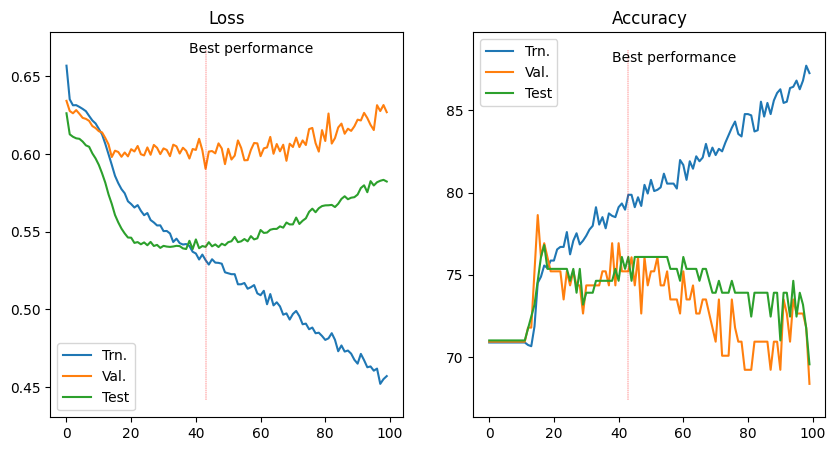

In [13]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(1,2,1)
ax.plot(results['loss']['trn'], label='Trn.')
ax.plot(results['loss']['val'], label='Val.')
ax.plot(results['loss']['test'], label='Test')
ax.vlines(best_ckpt['epoch'], *ax.axis()[2:], colors='red', linestyles='dashed', linewidth=0.3)
ax.text(best_ckpt['epoch']-5, max(ax.axis()[2:])*0.98, 'Best performance')
ax.legend()
ax.set_title('Loss')

ax = fig.add_subplot(1,2,2)
ax.plot(results['accuracy']['trn'], label='Trn.')
ax.plot(results['accuracy']['val'], label='Val.')
ax.plot(results['accuracy']['test'], label='Test')
ax.vlines(best_ckpt['epoch'], *ax.axis()[2:], colors='red', linestyles='dashed', linewidth=0.3)
ax.text(best_ckpt['epoch']-5, max(ax.axis()[2:])*0.98, 'Best performance')
ax.legend()
ax.set_title('Accuracy')

savepath_lc = os.path.join(savedir, 'learning_curve.png')
plt.savefig(savepath_lc)

# Test model

## Release GPU memory

In [14]:
del model, x, label, score
torch.cuda.empty_cache()

In [15]:
if model_type == 'base':
    model = BaseModel(img_type, backbone_freezing).to(device)
elif model_type == 'vgg16_grad_cam':
    model = VGG16GradCAM(img_type, backbone_freezing).to(device)
elif model_type == 'conv_att':
    model = ConvAttnModel(img_type, h_dim_attn, n_heads, h_dim_fc, n_layers, backbone_freezing).to(device)
else:
    raise ValueError("%s is invalid type"%model_type)

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
loadpath = os.path.join(savedir, 'model_best.ckpt')
ckpt = torch.load(loadpath)

print(ckpt['epoch'])
model.load_state_dict(ckpt['model_state_dict'])

43


<All keys matched successfully>

In [17]:
losses, preds, targets = [],[],[]
model.eval()
for x, label, score, info in dl_test:
    for i in range(len(x)):
        x[i] = x[i].to(device)
    score = score.to(device)

    y_pred = model(x)
    y_prob = y_pred.softmax(-1)[:,1]
    loss = F.binary_cross_entropy(y_prob, score)

    losses.append(loss.item())
    preds.extend(y_prob.detach().cpu())
    targets.extend(label)
acc, f1, auc, recall, precision, specificity = get_metrics(preds, targets)

open(os.path.join(savedir, 'Best_testset_loss_%6.2f_acc_%6.2f'%(np.mean(losses), acc)), 'w')
print('Best_testset_loss_%6.4f_acc_%6.2f'%(np.mean(losses), acc))

Best_testset_loss_0.5403_acc_ 76.09


In [18]:
def get_attention(model, img_type, imgs):
    def patch_attention(m):
        forward_orig = m.forward
    
        def wrap(*args, **kwargs):
            kwargs["need_weights"] = True
            kwargs["average_attn_weights"] = False
    
            return forward_orig(*args, **kwargs)
    
        m.forward = wrap
    attn_layers = []
    for i in range(len(img_type)):
        attn_layers.append(model.attns[i].layers[-1].self_attn)
        patch_attention(attn_layers[-1])
    
    vgg16_features, attn_inputs, attn_outputs = {_type:[] for _type in img_type}, {_type:[] for _type in img_type}, {_type:[] for _type in img_type}
    hooks = []
    for i, _type in enumerate(img_type):
        hooks.append(model.vgg16_models[i][-1].register_forward_hook(
            lambda self, input, output, _type=_type: vgg16_features[_type].append(output)
          ))
        hooks.append(attn_layers[i].register_forward_hook(
            lambda self, input, output, _type=_type: attn_inputs[_type].append(input[0])
          ))
        hooks.append(attn_layers[i].register_forward_hook(
            lambda self, input, output, _type=_type: attn_outputs[_type].append(output)
          ))
    
    pred_prob = model(imgs).softmax(-1)[:,1].item()
    
    # Self-attention
    for hook in hooks:
        hook.remove()
    
    return pred_prob, vgg16_features, attn_inputs, attn_outputs

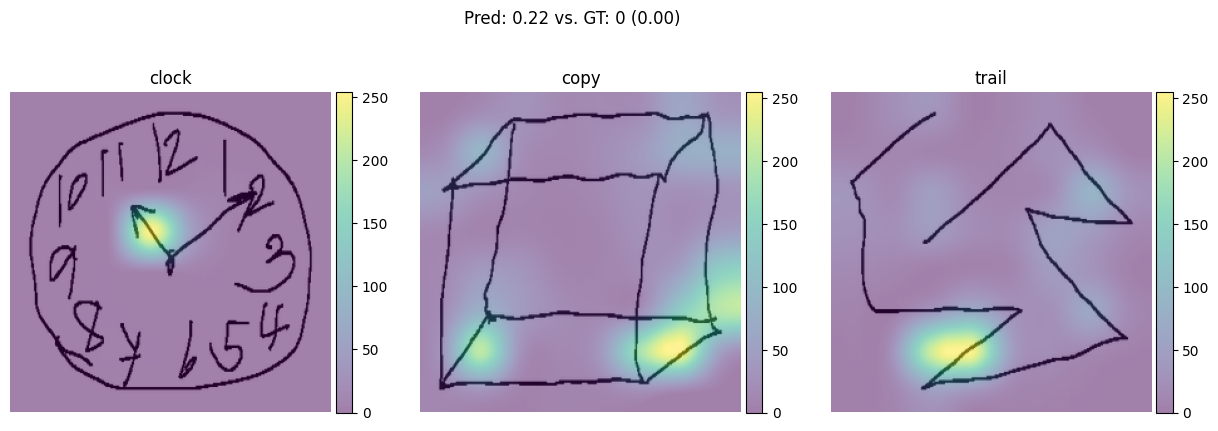

In [24]:
model.eval()
if model_type != 'base':
    _idx = 0
    patient_id = list(dataset_test.dataset.keys())[_idx]
    imgs = []
    for _type in img_type:
        imgs.append(dataset_test.dataset[patient_id]['image'][_type][None].to(device))
    score = dataset_test.dataset[patient_id]['score']
    label = dataset_test.dataset[patient_id]['label']
    
    if model_type == 'vgg16_grad_cam':
        pred_prob = model(imgs).softmax(-1)[:,1].item()
        pred_class = int(pred_prob > 0.5)
        heatmaps = [heatmap.cpu() for heatmap in model.generate_cam(imgs, pred_class)]
        
    elif model_type == 'conv_att':
        pred_prob, vgg16_features, attn_inputs, attn_outputs = get_attention(model, img_type, imgs)
    
        heatmaps = []
        for _type in img_type:
            B,C,H,W = vgg16_features[_type][0].shape
        
            attn_weights = attn_outputs[_type][0][1]
            heatmap = attn_weights[:,0,0,1:].reshape(B,H,W).detach().cpu()
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-7)
            # heatmap = torch.clamp(heatmap, min=0)
            # heatmap /= heatmap.max()
            heatmaps.append(heatmap)
    
    for i in range(len(heatmaps)):
        heatmaps[i] = np.uint8(255 * heatmaps[i])
        heatmaps[i] = np.uint8(Image.fromarray(heatmaps[i][0]).resize(IMAGE_SIZE))
        # heatmaps[i] = cv2.applyColorMap(heatmaps[i], cv2.COLORMAP_JET)
    
    fig = plt.figure(figsize=(5*len(img_type), 5))
    fig.suptitle(f'Pred: {pred_prob:0.2f} vs. GT: {label} ({score:0.2f})')
    for i, _type in enumerate(img_type):
        img = imgs[i].squeeze(0)
        img_rev = dataset.inverse_transform(img)
        
        ax = fig.add_subplot(1, len(img_type), i+1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
    
        im = ax.imshow(img_rev)   
        ax.set_title(_type)
        im = ax.imshow(heatmaps[i], alpha=0.5)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.axis('off')
    savepath_fig_res = os.path.join(savedir, 'results.png')
    plt.savefig(savepath_fig_res)

In [20]:
9048895184655194681
141371529023450027
9059304616452982690

9059304616452982690